In [1]:
# --------------------------------------------------------
# 
# Compare results from two feedstocks across application
# rate and particle size dimensions. 
# 
# Uses the `postproc_flxs` subdir to get the CDR inputs.
# 
# (this script replaces `cdr_cc-sil_compare-*` which was 
#  made before the postproc_flxs subdir code was created)
# 
# --------------------------------------------------------

In [25]:
# --- CDR calc note 
# --- from Yoshi (Jan 17, 2024)
# (-CO2_dif_exp-CO2_rsp_exp)-(-CO2_dif_spn-CO2_rsp_spn) - 0.14*(CO2_adv_exp - CO2_adv_spn).
# In the above equation CO2_dif denotes face values in the "diff" column for int_flux_gas-pco2.txt file,  
# CO2_adv in the column of "adv", CO2_rsp in the "g2" column (OM phase considered).  
# "exp" denotes ERW experiments while spn controls/spin-ups.

In [26]:
# --- Decide which CDR calculations to perform
cdr_calc_list = ["co2_flx",       
                 "camg_flx",
                 "totcat_flx",
                 # "carbalk_flx", # (turn this back on when the runs are re-run with fixed cflx file)
                 "rockdiss"]
# ---

In [27]:
import fnmatch
import glob
import os
import pickle
import re
from typing import Tuple

import cmocean.cm as cmo
import fsspec         # for AWS integration
import s3fs
from matplotlib.cm import ScalarMappable
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D  # for custom legend entries (needed for contour plot)
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import cdr_fxns_postproc as cfp


# --- 
runtype = "field"   # field or lab
fertlevel = "hi"   # "no", "low", "mid", or "hi"
dustsp = "gbas"     # "gbas", "wls" (silicate species)
sitename = "311a"   # "311a" or "311b"
multiyear_sil = False    # whether we are looking for multi-year composites for silicate case
multiyear_cc = False   # whether we are looking for multi-year composites for cc case
dur = '15'           # [yr], for file naming

tag_sil = "basev12"  # an extra tag in the casenames, something like "wet" (use "" for none)
tag_cc = "basev12"   # an extra tag in the casenames, something like "wet" (use "" for none)

version_sil_csv = "v0"   # version appended to the csv file for the batch input
version_cc_csv = "v0"

# --- SAVE DETAILS -----------------------------------------------------------------------------------------
save_results = True
if multiyear_sil or multiyear_cc:
    savedir_pref = f"meanAnn_shortRun_{fertlevel}Fert_{tag_sil}_multiyear"   # prefix for the save directory (which will be created upon save)
else:
    savedir_pref = f"meanAnn_shortRun_{fertlevel}Fert_{tag_sil}"   # prefix for the save directory (which will be created upon save)

savepath = "/home/tykukla/aglime-swap-cdr/scepter/process/runs/batch_postprocResults/cc-sil_psize_apprate"
# ----------------------------------------------------------------------------------------------------------


# [SILICATE RUNS]
if multiyear_sil:
    runname_ctrl_sil = [f"{fertlevel}Fert_{dustsp}_multiyear_site_{sitename}_app_0p0_psize_*_composite_{runtype}"]
    csv_fn_sil = f"meanAnn_{dustsp}_shortRun_multiyear_{fertlevel}Fert_gs+apprate_{version_sil_csv}.csv"
else:
    runname_ctrl_sil = [f"{fertlevel}Fert_{dustsp}_{tag_sil}_site_{sitename}_app_0p0_psize_*_{dustsp}_{runtype}_tau{dur}p0"]
    csv_fn_sil = f"meanAnn_{dustsp}_shortRun_{tag_sil}_{fertlevel}Fert_gs+apprate_{version_sil_csv}.csv"

# [CALCITE RUNS]
if multiyear_cc: 
    runname_ctrl_cc = [f"{fertlevel}Fert_cc_multiyear_site_{sitename}_app_0p0_psize_*_composite_{runtype}"]
    csv_fn_cc = f"meanAnn_cc_shortRun_multiyear_{fertlevel}Fert_gs+apprate_{version_cc_csv}.csv"
else:
    runname_ctrl_cc = [f"{fertlevel}Fert_cc_{tag_cc}_site_{sitename}_app_0p0_psize_*_cc_{runtype}_tau{dur}p0"]
    csv_fn_cc = f"meanAnn_cc_shortRun_{tag_cc}_{fertlevel}Fert_gs+apprate_{version_cc_csv}.csv"

# ---
# groundwork
# outdir = "/home/tykukla/SCEPTER/scepter_output"
outdir = "s3://carbonplan-carbon-removal/SCEPTER/scepter_output_scratch/"
csv_loc = "/home/tykukla/aglime-swap-cdr/scepter/batch-inputs"



In [28]:
# --- read in the batch .csv 
dfin_cc = pd.read_csv(os.path.join(csv_loc, csv_fn_cc))
dfin_sil = pd.read_csv(os.path.join(csv_loc, csv_fn_sil))

# [CALCITE]
# add column for the full run id
if multiyear_cc:
    dfin_cc["newrun_id_full"] = dfin_cc['newrun_id'] + f"_composite_{runtype}"
else:
    dfin_cc["newrun_id_full"] = dfin_cc['newrun_id'] + "_" + dfin_cc['dustsp'] + "_" + runtype + "_tau"+dfin_cc["duration"].astype(float).astype(str).str.replace(".", "p")  # (duration has to be turned into float first because otherwise we miss the decimal pt)
# identify the control run
dfin_cc["ctrl_run"] = dfin_cc['newrun_id_full'].apply(lambda filename: any(fnmatch.fnmatch(filename, pattern) for pattern in runname_ctrl_cc))
# eliminate other sites if necessary
if len(dfin_cc['site'].unique()) > 1:
    dfin_cc = dfin_cc[dfin_cc['site'] == f"site_{sitename}"].copy()
# add a column for the dustrate in ton_ha_yr
if "dustrate" in dfin_cc.columns:
    dfin_cc["dustrate_ton_ha_yr"] = dfin_cc["dustrate"] / 100 
    
# [SILICATE]
# add column for the full run id
if multiyear_sil:
    dfin_sil["newrun_id_full"] = dfin_sil['newrun_id'] + f"_composite_{runtype}"
else:
    dfin_sil["newrun_id_full"] = dfin_sil['newrun_id'] + "_" + dfin_sil['dustsp'] + "_" + runtype + "_tau"+dfin_sil["duration"].astype(float).astype(str).str.replace(".", "p")  # (duration has to be turned into float first because otherwise we miss the decimal pt)
# identify the control run
dfin_sil["ctrl_run"] = dfin_sil['newrun_id_full'].apply(lambda filename: any(fnmatch.fnmatch(filename, pattern) for pattern in runname_ctrl_sil))
# eliminate other sites if necessary
if len(dfin_sil['site'].unique()) > 1:
    dfin_sil = dfin_sil[dfin_sil['site'] == f"site_{sitename}"].copy()
# add a column for the dustrate in ton_ha_yr
if "dustrate" in dfin_sil.columns:
    dfin_sil["dustrate_ton_ha_yr"] = dfin_sil["dustrate"] / 100 


In [29]:
# # --- SCRATCH -- 
# # For multi-CTRL runs, select the control case that we want to use and omit the others
# ctrl_idx = 8
# n_ctrls = 8

# # get ctrl rows
# ctrl_sil_row = dfin_sil.iloc[n_ctrls-ctrl_idx].copy()
# ctrl_cc_row = dfin_cc.iloc[n_ctrls-ctrl_idx].copy()
# # set ctrl to true
# ctrl_sil_row.loc['ctrl_run'] = True
# ctrl_cc_row.loc['ctrl_run'] = True

# # drop everything else
# dfin_sil = dfin_sil.iloc[8:].reset_index(drop=True)
# dfin_cc = dfin_cc.iloc[8:].reset_index(drop=True)

# # add row back in
# dfin_sil = pd.concat([ctrl_sil_row.to_frame().T, dfin_sil], ignore_index=True)
# dfin_cc = pd.concat([ctrl_cc_row.to_frame().T, dfin_cc], ignore_index=True)


In [30]:
# # --- OPTIONAL: Filter out part of CSV

# # [1] by climatefile name (corresponds with site name)
# site = "site_311a"
# dfin_cc = dfin_cc[dfin_cc['climatefiles'] == 'site_311a']
# dfin_sil = dfin_sil[dfin_sil['climatefiles'] == 'site_311a']

# # [2] ... TK


In [31]:
dfin_cc['newrun_id_full'].values[2]

'hiFert_cc_basev12_site_311a_app_10p0_psize_10_cc_field_tau15p0'

In [32]:
dfin_sil

,dustrate,dustrad,site,spinrun,climatefiles,duration,dustsp,dustsp_2nd,dustrate_2nd,add_secondary,...,psdrain_log10_sd,psdrain_wt,use_psdrain_datfile,aws_save,aws_bucket,newrun_id,psdrain_meanRad,newrun_id_full,ctrl_run,dustrate_ton_ha_yr
0,0.0,1,site_311a,site_311a_pr9_spintuneup4,site_311a,15,gbas,amnt,30.0,False,...,0.2,1.0,False,move,s3://carbonplan-carbon-removal/SCEPTER/scepter...,hiFert_gbas_basev12_site_311a_app_0p0_psize_1,0.000001,hiFert_gbas_basev12_site_311a_app_0p0_psize_1_...,True,0.0
1,10.0,1,site_311a,site_311a_pr9_spintuneup4,site_311a,15,gbas,amnt,30.0,False,...,0.2,1.0,False,move,s3://carbonplan-carbon-removal/SCEPTER/scepter...,hiFert_gbas_basev12_site_311a_app_10p0_psize_1,0.000001,hiFert_gbas_basev12_site_311a_app_10p0_psize_1...,False,0.1
2,10.0,10,site_311a,site_311a_pr9_spintuneup4,site_311a,15,gbas,amnt,30.0,False,...,0.2,1.0,False,move,s3://carbonplan-carbon-removal/SCEPTER/scepter...,hiFert_gbas_basev12_site_311a_app_10p0_psize_10,0.000010,hiFert_gbas_basev12_site_311a_app_10p0_psize_1...,False,0.1
3,10.0,30,site_311a,site_311a_pr9_spintuneup4,site_311a,15,gbas,amnt,30.0,False,...,0.2,1.0,False,move,s3://carbonplan-carbon-removal/SCEPTER/scepter...,hiFert_gbas_basev12_site_311a_app_10p0_psize_30,0.000030,hiFert_gbas_basev12_site_311a_app_10p0_psize_3...,False,0.1
4,10.0,50,site_311a,site_311a_pr9_spintuneup4,site_311a,15,gbas,amnt,30.0,False,...,0.2,1.0,False,move,s3://carbonplan-carbon-removal/SCEPTER/scepter...,hiFert_gbas_basev12_site_311a_app_10p0_psize_50,0.000050,hiFert_gbas_basev12_site_311a_app_10p0_psize_5...,False,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,10000.0,100,site_311a,site_311a_pr9_spintuneup4,site_311a,15,gbas,amnt,30.0,False,...,0.2,1.0,False,move,s3://carbonplan-carbon-removal/SCEPTER/scepter...,hiFert_gbas_basev12_site_311a_app_10000p0_psiz...,0.000100,hiFert_gbas_basev12_site_311a_app_10000p0_psiz...,False,100.0
137,10000.0,125,site_311a,site_311a_pr9_spintuneup4,site_311a,15,gbas,amnt,30.0,False,...,0.2,1.0,False,move,s3://carbonplan-carbon-removal/SCEPTER/scepter...,hiFert_gbas_basev12_site_311a_app_10000p0_psiz...,0.000125,hiFert_gbas_basev12_site_311a_app_10000p0_psiz...,False,100.0
138,10000.0,150,site_311a,site_311a_pr9_spintuneup4,site_311a,15,gbas,amnt,30.0,False,...,0.2,1.0,False,move,s3://carbonplan-carbon-removal/SCEPTER/scepter...,hiFert_gbas_basev12_site_311a_app_10000p0_psiz...,0.000150,hiFert_gbas_basev12_site_311a_app_10000p0_psiz...,False,100.0
139,10000.0,200,site_311a,site_311a_pr9_spintuneup4,site_311a,15,gbas,amnt,30.0,False,...,0.2,1.0,False,move,s3://carbonplan-carbon-removal/SCEPTER/scepter...,hiFert_gbas_basev12_site_311a_app_10000p0_psiz...,0.000200,hiFert_gbas_basev12_site_311a_app_10000p0_psiz...,False,100.0


In [33]:
# --- decide which columns from dfin we want to keep when we 
#     create our flux dicts below
# 
# these should be the columns that become dimensions in the 
# later xr datasets... 
# 
dfin_cols_to_keep = ["dustrad", "dustrate_ton_ha_yr"]

In [34]:
# --- read in the postprocessed flux data for 'cc'
flx_dict_cc = cfp.read_postproc_flux(dfin_cc, outdir, cdr_calc_list, dfin_cols_to_keep, rockdiss_feedstock='cc')

solving co2_flx
solving camg_flx
solving totcat_flx
solving rockdiss


In [35]:
# --- read in the postprocessed flux data for sil
flx_dict_sil = cfp.read_postproc_flux(dfin_sil, outdir, cdr_calc_list, dfin_cols_to_keep, rockdiss_feedstock=dustsp)

solving co2_flx
solving camg_flx
solving totcat_flx
solving rockdiss


In [36]:
# plt.scatter(flx_dict_sil['co2_flx']['time'], flx_dict_sil['co2_flx']['co2flx_dif'])
flx_dict_sil['co2_flx'][flx_dict_sil['co2_flx']['ctrl'] == False]

,time,co2flx_dif,co2flx_tflx,co2flx_adv,g2,co2flx_resp,cc,co2flx_inorg,co2flx_adv_noinorg,units,flx_type,runname,var,ctrl,dustrad,dustrate_ton_ha_yr
64,0.000126,0.001367,0.000008,0.000035,-0.001407,-0.001407,-0.000003,-0.000003,0.000031,ton ha-1,int_flx,hiFert_gbas_basev12_site_311a_app_10p0_psize_1...,pco2,False,1,0.1
65,0.000376,0.004082,0.000020,0.000104,-0.004197,-0.004197,-0.000009,-0.000009,0.000095,ton ha-1,int_flx,hiFert_gbas_basev12_site_311a_app_10p0_psize_1...,pco2,False,1,0.1
66,0.001251,0.013605,0.000033,0.000346,-0.013965,-0.013965,-0.000020,-0.000020,0.000326,ton ha-1,int_flx,hiFert_gbas_basev12_site_311a_app_10p0_psize_1...,pco2,False,1,0.1
67,0.003751,0.040907,-0.000033,0.001038,-0.041872,-0.041872,-0.000039,-0.000039,0.000999,ton ha-1,int_flx,hiFert_gbas_basev12_site_311a_app_10p0_psize_1...,pco2,False,1,0.1
68,0.006251,0.068281,-0.000176,0.001730,-0.069779,-0.069779,-0.000055,-0.000055,0.001674,ton ha-1,int_flx,hiFert_gbas_basev12_site_311a_app_10p0_psize_1...,pco2,False,1,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,12.500001,97.616117,0.558480,17.043407,-119.288944,-119.288944,4.070940,4.070940,21.114347,ton ha-1,int_flx,hiFert_gbas_basev12_site_311a_app_10000p0_psiz...,pco2,False,300,100.0
9020,13.125001,100.851054,0.605833,18.193676,-124.162712,-124.162712,4.512148,4.512148,22.705824,ton ha-1,int_flx,hiFert_gbas_basev12_site_311a_app_10000p0_psiz...,pco2,False,300,100.0
9021,13.750001,103.976544,0.628506,19.352041,-128.936347,-128.936347,4.979255,4.979255,24.331297,ton ha-1,int_flx,hiFert_gbas_basev12_site_311a_app_10000p0_psiz...,pco2,False,300,100.0
9022,14.375001,107.042522,0.566162,20.596829,-133.654699,-133.654699,5.449187,5.449187,26.046015,ton ha-1,int_flx,hiFert_gbas_basev12_site_311a_app_10000p0_psiz...,pco2,False,300,100.0


In [37]:
# --- compute CDR fluxes for cc and sil (with losses considered)
# set the time_horizon for computing the integrated flux 
time_horizon = 15.
# ---
cdr_dict_full_cc, cdr_dict_sum_cc = cfp.cdr_int_per_group(flx_dict_cc, time_horizon, cdr_calc_list, dfin_cols_to_keep)
cdr_dict_full_sil, cdr_dict_sum_sil = cfp.cdr_int_per_group(flx_dict_sil, time_horizon, cdr_calc_list, dfin_cols_to_keep)

solving co2_flx
solving camg_flx
solving totcat_flx
solving rockdiss
solving co2_flx
solving camg_flx
solving totcat_flx
solving rockdiss


In [38]:
# --- get emissions 
dustrate_name = "dustrate_ton_ha_yr" # note, we multiply by duration in emissions_calc, so we only want annual rate here
# set the inputs ***************
p80_inputcc, p80_inputsil = 1.3e3, 1.3e3
truck_kmcc, truck_kmsil = 0.0e3, 0.0e3
barge_kmcc, barge_kmsil = 0.1e3, 0.1e3
barge_diesel_kmcc, barge_diesel_kmsil = 0, 0
Efactor_orgcc, Efactor_orgsil = "MRO", "MRO"
# ******************************

# [CALCITE]
cdr_dict_sum_cc['rockdiss'] = cfp.emissions_calculator_df(cdr_dict_sum_cc['rockdiss'], dustrate_name, 
                                                        p80_inputcc, truck_kmcc, barge_kmcc, barge_diesel_kmcc, 
                                                        Efactor_orgcc, mineral="cc")
# [SILICATE]
cdr_dict_sum_sil['rockdiss'] = cfp.emissions_calculator_df(cdr_dict_sum_sil['rockdiss'], dustrate_name, 
                                                        p80_inputsil, truck_kmsil, barge_kmsil, barge_diesel_kmsil, 
                                                        Efactor_orgsil, mineral=dustsp)


In [39]:
# --- compute CDR w/ loss rates and convert to xr datasets
outds_cc = cfp.cdr_ds(cdr_dict = cdr_dict_sum_cc, dims = dfin_cols_to_keep, cdr_calc_list = cdr_calc_list)
outds_sil = cfp.cdr_ds(cdr_dict = cdr_dict_sum_sil, dims = dfin_cols_to_keep, cdr_calc_list = cdr_calc_list)

# combine xr datasets as dict
cdr_ds_dict = {"cc": outds_cc, dustsp: outds_sil}

solving co2_flx
solving camg_flx
solving totcat_flx
solving rockdiss
solving co2_flx
solving camg_flx
solving totcat_flx
solving rockdiss


In [40]:
# # [ !! WIP !! SCRATCH-turn emissions vars into dimensions (rather than being stuck with a single dimension)]
# ds = outds_cc.copy()

# # define emissions dimensions (these would be inputs to the fxn)
# truck_km = np.linspace(10, 200, 10)
# barge_km = np.linspace(10, 200, 10)
# barge_diesel_km = np.linspace(10, 200, 10)
# p80_input = np.linspace(1000, 10000, 10)



In [41]:
# --- compute netCDR relative to a counterfactual dust
#     application scenario
# ******* DEFINE THE COUNTERFACTUAL ********* 
counterfact_fs = "cc"   # counterfactual feedstock type
cf_apprate_fixed = 0.6 # 0.6   # counterfactual rock application rate
cf_dustrad_fixed = 100   # counterfactual dust application rate
select_nearest_cfdust = True  # whether to use nearest dust pars if these specific values aren't in the ds
# ********************************************
ds_anom = cfp.cdr_fs_vs_counterfactual(cdr_ds_dict, counterfact_fs, cf_apprate_fixed, cf_dustrad_fixed, select_nearest_cfdust)

In [42]:
# -------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------

In [43]:
# --- save results **************************************************************************
# 
if save_results:
    # create the dictionary we'll save as the resource file
    savedict = cfp.create_save_dict(cdr_calc_list, dfin_cols_to_keep,
                                    csv_fn_sil, csv_fn_cc, multiyear_sil,
                                    multiyear_cc, time_horizon, cf_apprate_fixed,
                                    cf_dustrad_fixed, p80_inputsil, p80_inputcc, 
                                    truck_kmsil, truck_kmcc, barge_kmsil, barge_kmcc,
                                    barge_diesel_kmsil, barge_diesel_kmcc, 
                                    Efactor_orgsil, Efactor_orgcc)
    
    # write the files
    fname_res = "_calc_inputs.res"    # name of the resource file we'll save
    saved_here = cfp.save_batch_postproc(savedict, savepath, savedir_pref, fname_res,
                            cdr_dict_sum_sil, cdr_dict_sum_cc, outds_sil, 
                            outds_cc, ds_anom)
# *********************************************************************************************    

Directory created: /home/tykukla/aglime-swap-cdr/scepter/process/runs/batch_postprocResults/cc-sil_psize_apprate/meanAnn_shortRun_hiFert_basev12_001


## PROFILE POSTPROCESSING:

In [44]:
# --- prepare the post-processing inputs
# 
batch_axes = dfin_cols_to_keep
#
# dictionary for which files to process in the batch profile functions
proc_dict = {
    "adsorbed": False,
    "adsorbed_percCEC": True,
    "adsorbed_ppm": False,
    "aqueous": True,
    "aqueous_total": False,
    "bulksoil": True,
    "exchange_total": False,
    "gas": True,
    "rate": False,
    "soil_ph": True,
    "solid": False,
    "solid_sp_saturation": True, 
    "solid_volumePercent": True,
    "solid_weightPercent": True,
    "specific_surface_area": True,
    "surface_area": False,
}


In [45]:
# --- compile all the profile .nc data into a single dataset
#

# [silicate]
dsdict_sil = cfp.prof_batchprocess_allvars(outdir, dustsp, dfin_sil, batch_axes, proc_dict, print_loop_updates = False)

compiling profile data for gbas


In [46]:
# [carbonate]
dsdict_cc = cfp.prof_batchprocess_allvars(outdir, "cc", dfin_cc, batch_axes, proc_dict, print_loop_updates = False)
dsdict_cc.keys()

compiling profile data for cc


dict_keys(['adsorbed_percCEC', 'aqueous', 'bulksoil', 'gas', 'soil_ph', 'solid_sp_saturation', 'solid_volumePercent', 'solid_weightPercent', 'specific_surface_area'])

In [47]:
# --- save the postprocessed results
# 
# [silicate]
cfp.save_batch_postproc_profOnly(dsdict_sil, dustsp, save_directory = saved_here)

# [carbonate]
cfp.save_batch_postproc_profOnly(dsdict_cc, "cc", save_directory = saved_here)

'/home/tykukla/aglime-swap-cdr/scepter/process/runs/batch_postprocResults/cc-sil_psize_apprate/meanAnn_shortRun_hiFert_basev12_001'

# -------------------------------------------------------------
# -------------------------------------------------------------

In [18]:
savepath = "s3://carbonplan-carbon-removal/SCEPTER/scepter_output_scratch/hiFert_cc_AWS-TEST_site_311a_app_0p0_psize_10_cc_field_tau15p0"
# outdir = "s3://carbonplan-carbon-removal/SCEPTER/scepter_output_scratch/hiFert_cc_AWS-TEST_site_311a_app_0p0_psize_10_cc_field_tau15p0/meanAnn_shortRun_hiFert_AWS-TEST_004"
# path = os.path.join(outdir, "ds_sil.nc")

# ds = xr.Dataset(
#     {"temperature": ("time", [20, 21, 22, 23, 24])},
#     coords={"time": [0, 1, 2, 3, 4]},
# )

# ds.to_netcdf(path)
# # with fsspec.open(outdir, 'wb'):
# # outds_sil.to_netcdf(os.path.join(outdir, "ds_sil.nc"), engine='h5netcdf')

In [ ]:
# ----------------------------------------------
# SCRATCH PLOTS BELOW THIS
# 
# 
# 
# 
# 
# 
# 
# 
# 

In [22]:
ds_anom.keys()

KeysView(<xarray.Dataset> Size: 4MB
Dimensions:                  (dustrad: 9, dustrate_ton_ha_yr: 13,
                              loss_percent: 50, cdr_calc: 5, feedstock: 2)
Coordinates:
  * dustrad                  (dustrad) int64 72B 1 10 30 50 75 100 125 150 200
  * dustrate_ton_ha_yr       (dustrate_ton_ha_yr) float64 104B 0.3 0.6 ... 100.0
  * loss_percent             (loss_percent) float64 400B 1.0 3.02 ... 100.0
  * cdr_calc                 (cdr_calc) <U20 400B 'netR' ... 'conservative'
  * feedstock                (feedstock) object 16B 'cc' 'gbas'
Data variables:
    cdr_dif                  (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 468kB ...
    cdr_adv                  (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 468kB ...
    cdr_adv_plus_newSIC      (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 468kB ...
    cdr_SIConly              (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, lo

(0.2, 60)

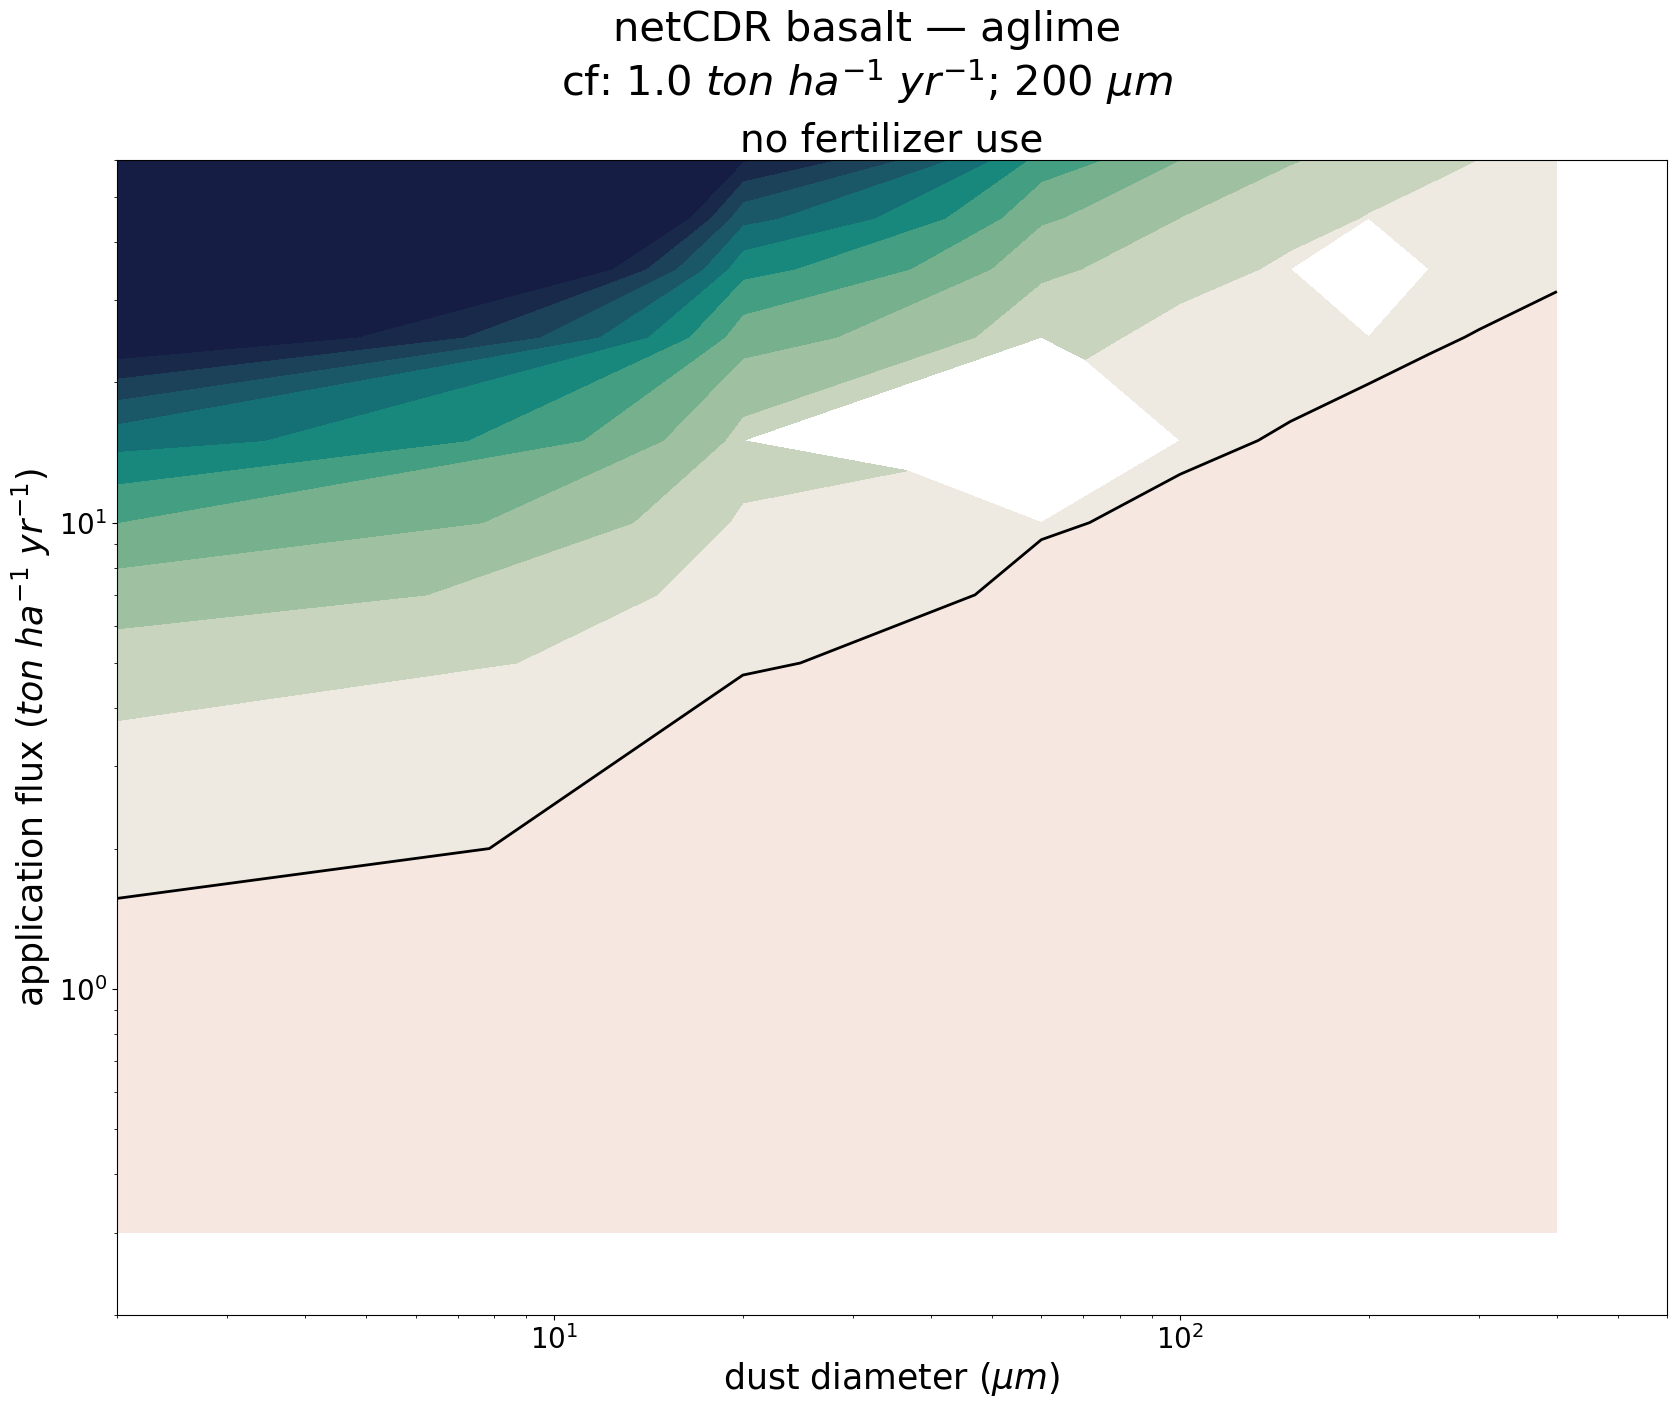

In [34]:
# --- PLOT --------------------
# set data conditions
feedstock = 'gbas'
cdr_var = 'cdr_adv' # 'co2pot_adv_tonHa_camg' 
loss_percent = 10
cdr_calc = 'netR_noNeg'
logX = True
logY = True

# pull out the data we want
dsanom1_p4 = ds_anom.sel(feedstock=feedstock, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
# dsanom2_p4 = ds_anom2.sel(feedstock=feedstock, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dsanom1_p4 = dsanom1_p4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
# dsanom2_p4 = dsanom2_p4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
fertLevel_1 = fertlevel
# *****************************
# --- plot aesthetics
# color palette
col = cmo.curl_r
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 60 
# *****************************

# x and y arrays
# [fertlevel 1]
x1 = dsanom1_p4['dustrad'].values
y1 = dsanom1_p4['dustrate_ton_ha_yr'].values
# [fertlevel 2]
# x2 = dsanom2_p4['dustrad'].values
# y2 = dsanom2_p4['dustrate_ton_ha_yr'].values

# pull out cf dustrate and dustrad
cf_apprate = ds_anom.cf_apprate.values
cf_dustrad = ds_anom.cf_dustrad.values


# --- SET UP PLOT
spec = GridSpec(ncols=1, nrows=1, hspace=0.2)
plt.figure(figsize=(20,15))

# --- fertlevel 1
ax = plt.subplot(spec[0])
contour = plt.contourf(x1*2,y1,dsanom1_p4.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x1*2,y1,dsanom1_p4.transpose(),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.suptitle(f"netCDR basalt — aglime\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
plt.title(f"\n{fertLevel_1} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- fertlevel 2
# ax = plt.subplot(spec[1])
# contour = plt.contourf(x2*2,y2,dsanom2_p4.transpose(), 
#                         levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
# contour_line = plt.contour(x2*2,y2,dsanom2_p4.transpose(),levels=[0], colors='black', linewidths=2)
# plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
# plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
# plt.tick_params(axis='both', labelsize=fs_tick)
# plt.title(f"\n{fertLevel_2} fertilizer use", fontsize=fs_title_sub)
# (plt.xscale('log') if logX else "")
# (plt.yscale('log') if logY else "")
# plt.xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
# cbar = plt.colorbar(contour)
# cbar.set_label(r"$netCDR\ (\text{tons}\ \text{ha}^{-1})$", fontsize=fs_cbarlab)
# cbar.ax.tick_params(labelsize=fs_cbartick)
# # plt.yscale('log')


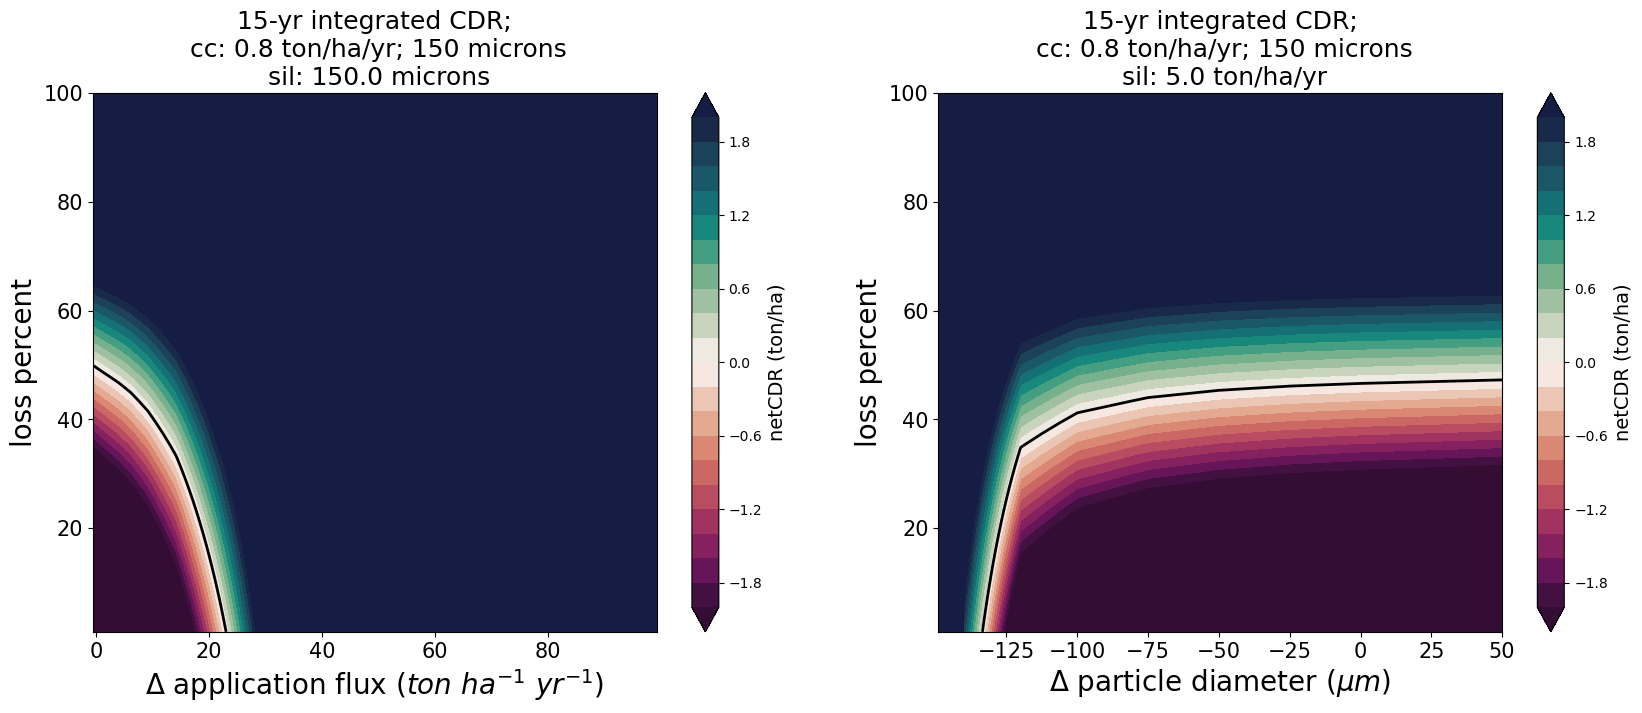

In [49]:
# --- PLOT netCDR against loss for both app rate and particle size

# select variable to plot in contour
pvar = "net_R"
# color palette
col = cmo.curl_r
# set static values
static_dustrad = 0.     # method=nearest used for finding the value to fix
static_apprate = 5   # method=nearest used for finding the value to fix
# set fontsizes
fs_xlab = 20     # x title
fs_ylab = 20     # y title
fs_tick = 15     # ticks, bot haxes
fs_title = 18    # plot title
fs_cbarlab = 14  # colorbar title
fs_cbartick = 10 # colorbar ticks
# color limits
cmin, cmax = -2, 2
# x-axis limits
# set x and y arrs
y = ds['loss_percent'].values
x1 = ds_anom['D_apprate'].values
x2 = ds_anom['D_dustrad'].values
x1min, x1max = min(x1), 7
x2min, x2max = min(x2), max(x2)

# set time horizon
time_horizon = ds_anom.timehorizon_yr.values
cc_app_fixed = ds_anom.cc_apprate_fixed.values
cc_dust_fixed = ds_anom.cc_dustrad_fixed.values

# set plot title text
sildust = static_dustrad + cc_dust_fixed
silapp = ds_anom.sel(D_apprate = static_apprate, method='nearest').D_apprate.values + cc_app_fixed
p1text = str(time_horizon) + '-yr integrated CDR;\n ' + "cc: " + str(cc_app_fixed) + " ton/ha/yr; " + str(cc_dust_fixed) + " microns\n " + "sil: " + str(sildust) + " microns"
p2text = str(time_horizon) + '-yr integrated CDR;\n ' + "cc: " + str(cc_app_fixed) + " ton/ha/yr; " + str(cc_dust_fixed) + " microns\n " + "sil: " + str(silapp) + " ton/ha/yr"

# Define the midpoint normalization
# norm = TwoSlopeNorm(vmin=ds_anom[pvar].min(), vmax=ds_anom[pvar].max(), vcenter=0)
norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# set up grid 
spec = GridSpec(ncols=2, nrows=1, hspace=0.02)
plt.figure(figsize=(20,7))

# PLOT 1
ax = plt.subplot(spec[0])
contour = plt.contourf(x1,y,ds_anom.sel(D_dustrad = static_dustrad, method='nearest')[pvar], 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend="both")
# add zero contour line
contour_line = plt.contour(x1, y, ds_anom.sel(D_dustrad = static_dustrad, method='nearest')[pvar], 
                            levels=[0], colors='black', linewidths=2)
cbar = plt.colorbar(contour)
cbar.set_label('netCDR (ton/ha)', fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
plt.title(p1text, fontsize=fs_title)
plt.xlabel(r"$\Delta$ application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.ylabel("loss percent", fontsize=fs_ylab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.xscale('log')
# plt.xlim(x1min, x1max)

# PLOT 2
ax = plt.subplot(spec[1])
contour = plt.contourf(x2,y,ds_anom.sel(D_apprate = static_apprate, method='nearest')[pvar], 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend="both")
# add zero contour line
contour_line = plt.contour(x2, y,ds_anom.sel(D_apprate = static_apprate, method='nearest')[pvar],
                            levels=[0], colors='black', linewidths=2)
cbar = plt.colorbar(contour)
cbar.set_label('netCDR (ton/ha)', fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
plt.title(p2text, fontsize=fs_title)
plt.xlabel(r"$\Delta$ particle diameter $(\mu m)$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.xlim(x2min, x2max)
plt.ylabel("loss percent", fontsize=fs_ylab)

plt.show();

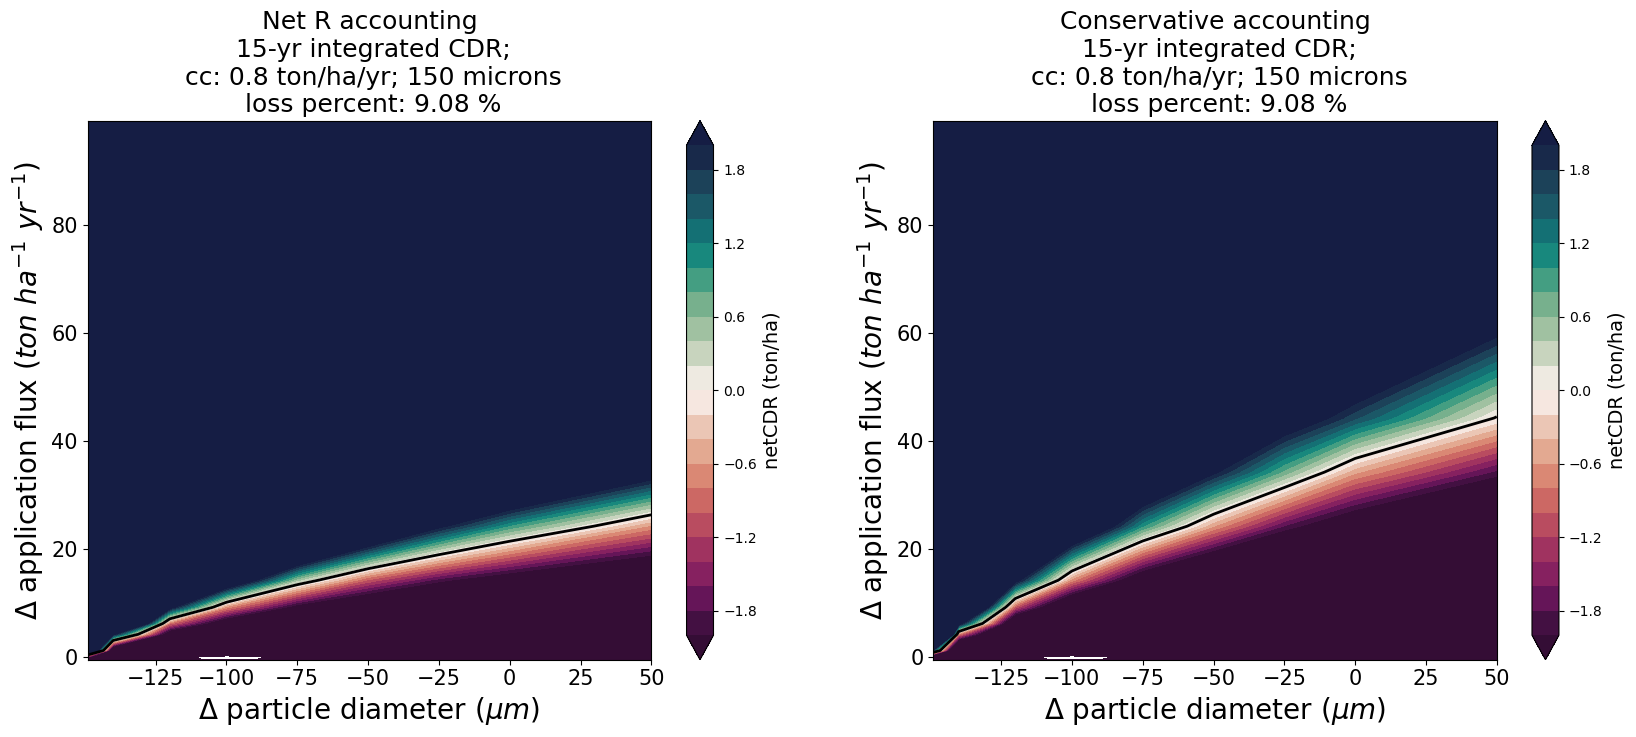

In [55]:
# --- PLOT for a given loss percent, what is the trade off contour for each accounting approach (4 PANEL)
# select the zero-contours to plot
pvar1 = "net_R"
# pvar2 = "simple_subtract"    # omitted for now..
# pvar3 = "no_negatives"
pvar4 = "conservative"
# color palette
col = cmo.curl_r

# set static values
static_losspercent = 10 # method=nearest usef for finding the value to fix
# set fontsizes
fs_xlab = 20     # x title
fs_ylab = 20     # y title
fs_tick = 15     # ticks, bot haxes
fs_title = 18    # plot title
fs_leg = 15      # legend text
# linewidth
lwds = 2
# x-axis limits
# set x and y arrs
# pull out the dataset to plot
loss_percent_plotted = ds_anom.sel(loss_percent=static_losspercent, method='nearest').loss_percent.values
dsp = ds_anom.sel(loss_percent=static_losspercent, method='nearest')
x = dsp['D_dustrad'].values
y = dsp['D_apprate'].values
ymin, ymax = min(y), 70
xmin, xmax = min(x), max(x)

# set time horizon
time_horizon = ds_anom.timehorizon_yr.values
cc_app_fixed = ds_anom.cc_apprate_fixed.values
cc_dust_fixed = ds_anom.cc_dustrad_fixed.values

# set plot title 
ptext1 = "Net R accounting\n " + str(time_horizon) + '-yr integrated CDR;\n ' + "cc: " + str(cc_app_fixed) + " ton/ha/yr; " + str(cc_dust_fixed) + " microns\n " + "loss percent: " + str(np.round(loss_percent_plotted, 2)) + " %"
ptext2 = "Conservative accounting\n " + str(time_horizon) + '-yr integrated CDR;\n ' + "cc: " + str(cc_app_fixed) + " ton/ha/yr; " + str(cc_dust_fixed) + " microns\n " + "loss percent: " + str(np.round(loss_percent_plotted, 2)) + " %"

# Define the midpoint normalization
norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)



# set up grid 
spec = GridSpec(ncols=2, nrows=1, hspace=0.02)
plt.figure(figsize=(20,7))

# --- PLOT 1
ax = plt.subplot(spec[0])
contour = plt.contourf(x,y,dsp[pvar1], levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend="both")
# add zero contour line
contour_line = plt.contour(x,y,dsp[pvar1],levels=[0], colors='black', linewidths=2)
cbar = plt.colorbar(contour)
cbar.set_label('netCDR (ton/ha)', fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
plt.title(ptext1, fontsize=fs_title)
plt.ylabel(r"$\Delta$ application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.xlabel(r"$\Delta$ particle diameter $(\mu m)$", fontsize=fs_ylab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.xscale('log')
plt.xlim(xmin, xmax)

# --- PLOT 2
ax = plt.subplot(spec[1])
contour = plt.contourf(x,y,dsp[pvar4], levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend="both")
# add zero contour line
contour_line = plt.contour(x,y,dsp[pvar4],levels=[0], colors='black', linewidths=2)
cbar = plt.colorbar(contour)
cbar.set_label('netCDR (ton/ha)', fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
plt.title(ptext2, fontsize=fs_title)
plt.ylabel(r"$\Delta$ application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.xlabel(r"$\Delta$ particle diameter $(\mu m)$", fontsize=fs_ylab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.xscale('log')
plt.xlim(xmin, xmax)

plt.show();


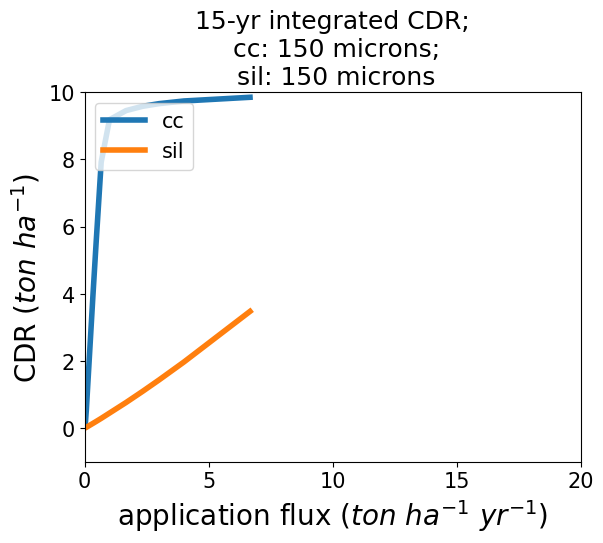

In [15]:
# ---- PLOT cc vs sil across app rates
cc_dustrad_fixed = 150
sil_dustrad_fixed = 150


# set fontsizes
fs_ylab = 20     # x title
fs_xlab = 20     # y title
fs_tick = 15     # ticks, bot haxes
fs_title = 18    # plot title
fs_leg = 15      # legend text
# linewidth
lwds = 4
# tmp dfs to plot 
sil_tmp = dfsil_sum[dfsil_sum['dustrad'] == sil_dustrad_fixed]
cc_tmp = dfcc_sum[dfcc_sum['dustrad'] == cc_dustrad_fixed]

# name the title 
time_horizon = cc_tmp['timehorizon_yr'].values[0]
ptext = str(time_horizon) + '-yr integrated CDR;\n ' + "cc: " + str(cc_dustrad_fixed) + " microns;\n " + "sil: " + str(sil_dustrad_fixed) + " microns"

plt.plot(cc_tmp[dustrate_name], cc_tmp['cdr'], label='cc', linewidth=lwds)
plt.plot(sil_tmp[dustrate_name], sil_tmp['cdr'], label='sil', linewidth=lwds)
plt.xlim(0, 20)
plt.ylim(-1, 10)
plt.title(ptext, fontsize=fs_title)
plt.xlabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.ylabel(r"CDR $(ton\ ha^{-1})$", fontsize=fs_ylab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.xscale('log')
# plt.ylim(x1min, x1max)
plt.legend(fontsize=fs_leg, loc='upper left')

plt.show();

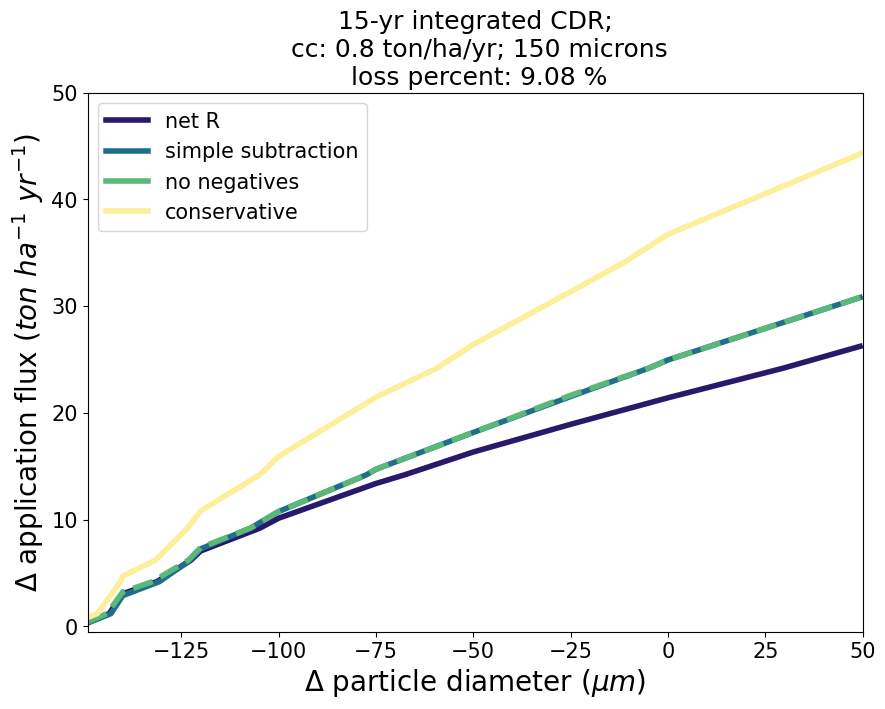

In [106]:
# --- PLOT as above but AXES SWAPPED

# select the zero-contours to plot
pline1 = "net_R"
pline2 = "simple_subtract"
pline3 = "no_negatives"
pline4 = "conservative"
# color palette
# col = cmo.thermal(np.linspace(0, 1, 4))  
col = [tuple(color) for color in cmo.haline(np.linspace(0, 1, 4))]

# set static values
static_losspercent = 10 # method=nearest usef for finding the value to fix
# set fontsizes
fs_ylab = 20     # x title
fs_xlab = 20     # y title
fs_tick = 15     # ticks, bot haxes
fs_title = 18    # plot title
fs_leg = 15      # legend text
# linewidth
lwds = 4
# axis limits
# set x and y arrs
# pull out the dataset to plot
loss_percent_plotted = ds_anom.sel(loss_percent=static_losspercent, method='nearest').loss_percent.values
dsp = ds_anom.sel(loss_percent=static_losspercent, method='nearest')
x = dsp['D_dustrad'].values
y = dsp['D_apprate'].values
x1min, x1max = min(x1), max(x2)
x2min, x2max = min(x2), max(x2)

# set time horizon
time_horizon = ds_anom.timehorizon_yr.values
cc_app_fixed = ds_anom.cc_apprate_fixed.values
cc_dust_fixed = ds_anom.cc_dustrad_fixed.values

# set plot title 
ptext = str(time_horizon) + '-yr integrated CDR;\n ' + "cc: " + str(cc_app_fixed) + " ton/ha/yr; " + str(cc_dust_fixed) + " microns\n " + "loss percent: " + str(np.round(loss_percent_plotted, 2)) + " %"

# set up grid 
spec = GridSpec(ncols=1, nrows=1, hspace=0.02)
plt.figure(figsize=(10,7))

# --- PLOT 
ax = plt.subplot(spec[0])
# contour line 1 and custom legend entry
contour_line1 = plt.contour(x, y, dsp[pline1], levels=[0], colors=col, linewidths=lwds)
legend_line1 = Line2D([0], [0], color=col[0], linewidth=lwds, label='net R')
# contour line 2
contour_line2 = plt.contour(x, y, dsp[pline2], levels=[0], colors=col[1:], linewidths=lwds)
legend_line2 = Line2D([0], [0], color=col[1], linewidth=lwds, label='simple subtraction')
# contour line 3
contour_line3 = plt.contour(x, y, dsp[pline3], levels=[0], colors=col[2:], linewidths=lwds, linestyles='--')
legend_line3 = Line2D([0], [0], color=col[2], linewidth=lwds, label='no negatives')
# contour line 4
contour_line4 = plt.contour(x, y, dsp[pline4], levels=[0], colors=col[3:], linewidths=lwds)
legend_line4 = Line2D([0], [0], color=col[3], linewidth=lwds, label='conservative')
plt.title(ptext, fontsize=fs_title)
plt.ylabel(r"$\Delta$ application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.xlabel(r"$\Delta$ particle diameter $(\mu m)$", fontsize=fs_ylab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.xscale('log')
plt.ylim(x1min, x1max)
plt.legend(handles=[legend_line1, legend_line2, legend_line3, legend_line4], fontsize=fs_leg, loc='upper left')

plt.show();

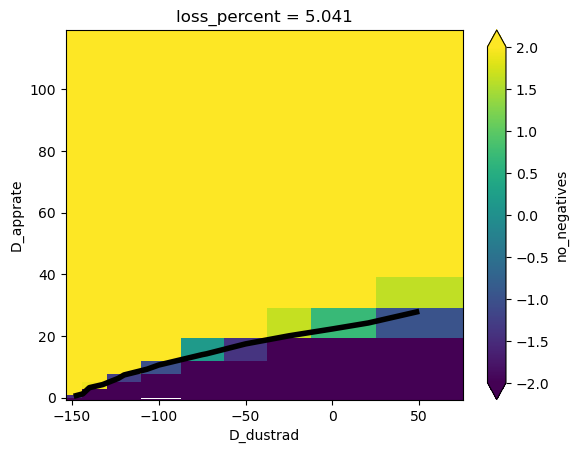

In [103]:
# ds_anom.sel(loss_percent = 5, method='nearest')['simple_subtract'].plot()
# ds_anom.sel(loss_percent = 5, method='nearest')['no_negatives'].plot()
# (ds_anom.sel(loss_percent = 5, method='nearest')['no_negatives'] - ds_anom.sel(loss_percent = 5, method='nearest')['simple_subtract']).plot()

dsxtmp = ds_anom.sel(loss_percent = 5, method='nearest')

ds_anom.sel(loss_percent = 5, method='nearest')['no_negatives'].plot(vmin=-2, vmax=2)
contour = plt.contour(x, y, dsxtmp['no_negatives'], levels=[0], colors='black', linewidths=lwds)

#ds_anom.sel(loss_percent = 5, method='nearest')['simple_subtract'].plot(vmin=-2, vmax=2)
#contour = plt.contour(x, y, dsxtmp['simple_subtract'], levels=[0], colors='black', linewidths=lwds)

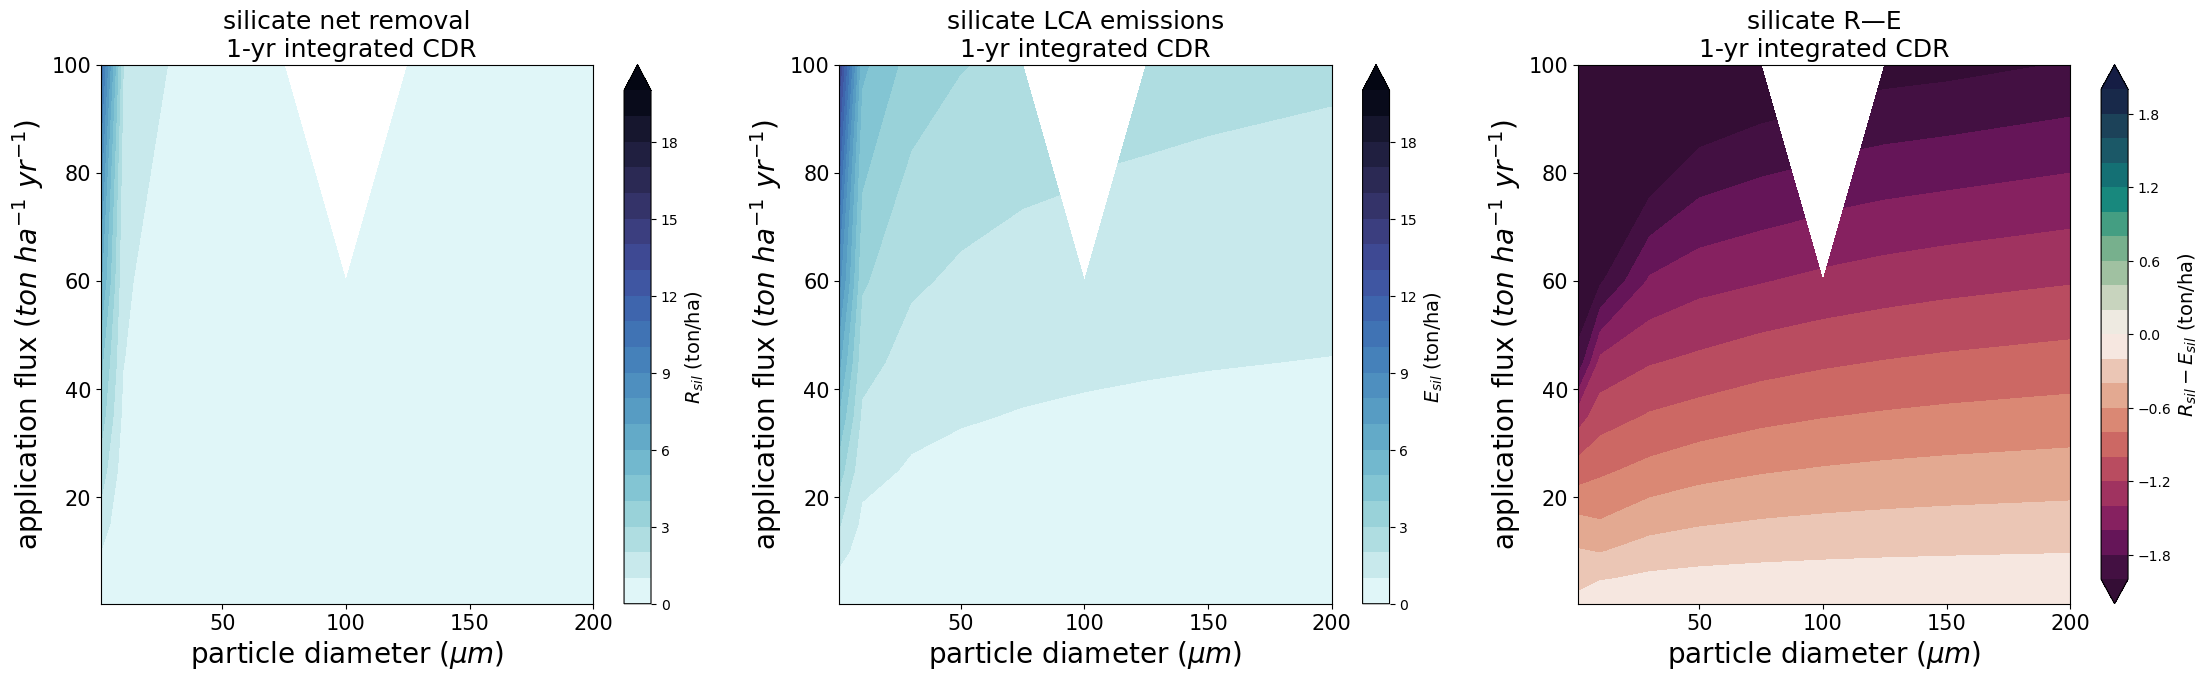

In [83]:
# --- PLOT decompose the silicate R and E 
# select variable to plot in contour
pvar1 = "sil_R"
pvar2 = "sil_E"
pvar3 = "sil_R_E"
# color palette
col12 = cmo.ice_r
col3 = cmo.curl_r
# set static values
static_losspercent = 10 # method=nearest usef for finding the value to fix
# set fontsizes
fs_xlab = 20     # x title
fs_ylab = 20     # y title
fs_tick = 15     # ticks, bot haxes
fs_title = 18    # plot title
fs_cbarlab = 14  # colorbar title
fs_cbartick = 10 # colorbar ticks
# color limits
cmin12, cmax12 = 0, 20
cmin3, cmax3 = -2, 2
# axis limits
# set x and y arrs
# pull out the dataset to plot
loss_percent_plotted = ds.sel(loss_percent=static_losspercent, method='nearest').loss_percent.values
dsp = ds.sel(loss_percent=static_losspercent, method='nearest')
x = dsp['dustrad'].values
y = dsp['apprate'].values
ymin, ymax = min(y), 70
xmin, xmax = min(x), max(x)

# set time horizon
time_horizon = ds.timehorizon_yr.values

# set plot title 
ptext1 = "silicate net removal\n " + str(time_horizon) + '-yr integrated CDR'
ptext2 = "silicate LCA emissions\n" + str(time_horizon) + '-yr integrated CDR'
ptext3 = "silicate R—E\n" + str(time_horizon) + '-yr integrated CDR'

# Define the midpoint normalization for diverging bar
norm = TwoSlopeNorm(vmin=cmin3, vmax=cmax3,vcenter=0)


# set up grid 
spec = GridSpec(ncols=3, nrows=1, hspace=0.02)
plt.figure(figsize=(27,7))

# --- PLOT 1
ax = plt.subplot(spec[0])
contour = plt.contourf(x,y,dsp[pvar1], levels=np.linspace(cmin12, cmax12, 21), cmap = col12, vmin=cmin12, vmax=cmax12, extend="max")
cbar = plt.colorbar(contour)
cbar.set_label(r'$R_{sil}$ (ton/ha)', fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
plt.title(ptext1, fontsize=fs_title)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.xlabel(r"particle diameter $(\mu m)$", fontsize=fs_ylab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.xscale('log')
plt.xlim(xmin, xmax)

# --- PLOT 2
ax = plt.subplot(spec[1])
contour = plt.contourf(x,y,dsp[pvar2], levels=np.linspace(cmin12, cmax12, 21), cmap = col12, vmin=cmin12, vmax=cmax12, extend="max")
cbar = plt.colorbar(contour)
cbar.set_label(r'$E_{sil}$ (ton/ha)', fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
plt.title(ptext2, fontsize=fs_title)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.xlabel(r"particle diameter $(\mu m)$", fontsize=fs_ylab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.xscale('log')
plt.xlim(xmin, xmax)

# --- PLOT 3
ax = plt.subplot(spec[2])
contour = plt.contourf(x,y,dsp[pvar3], levels=np.linspace(cmin3, cmax3, 21), cmap = col3, vmin=cmin3, vmax=cmax3, extend="both")
cbar = plt.colorbar(contour)
cbar.set_label(r'$R_{sil}-E_{sil}$ (ton/ha)', fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
plt.title(ptext3, fontsize=fs_title)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.xlabel(r"particle diameter $(\mu m)$", fontsize=fs_ylab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.xscale('log')
plt.xlim(xmin, xmax)


plt.show();


(1.0, 200.0)

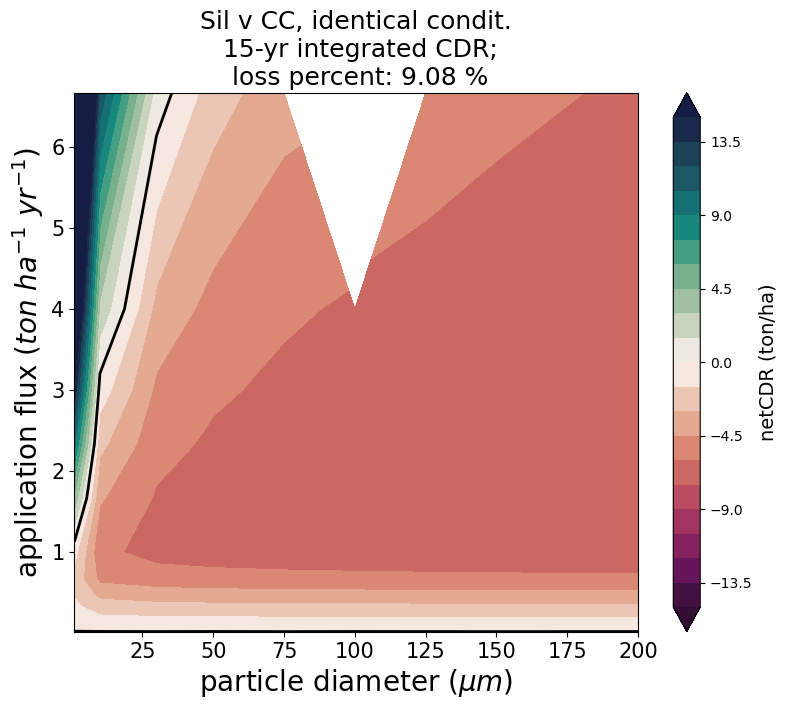

In [61]:
# --- PLOT sil vs cc R for all the same inputs
# select the zero-contours to plot
silvar = "sil_R"
ccvar = "cc_R"
# color palette
col = cmo.curl_r
cmin, cmax = -15, 15

# set static values
static_losspercent = 10 # method=nearest usef for finding the value to fix
# set fontsizes
fs_xlab = 20     # x title
fs_ylab = 20     # y title
fs_tick = 15     # ticks, bot haxes
fs_title = 18    # plot title
fs_leg = 15      # legend text
# linewidth
lwds = 2
# x-axis limits
# set x and y arrs
# pull out the dataset to plot
loss_percent_plotted = ds.sel(loss_percent=static_losspercent, method='nearest').loss_percent.values
ds_filt = ds.sel(loss_percent=static_losspercent, method='nearest')
x = ds_filt['dustrad'].values
y = ds_filt['apprate'].values
ymin, ymax = min(y), max(y)
xmin, xmax = min(x), max(x)

# set time horizon
time_horizon = ds.timehorizon_yr.values

# set plot title 
ptext1 = "Sil v CC, identical condit.\n " + str(time_horizon) + '-yr integrated CDR;\n ' + "loss percent: " + str(np.round(loss_percent_plotted, 2)) + " %"

# Define the midpoint normalization
norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)



# set up grid 
spec = GridSpec(ncols=2, nrows=1, hspace=0.02)
plt.figure(figsize=(20,7))

# --- PLOT 1
ax = plt.subplot(spec[0])
contour = plt.contourf(x,y,(ds_filt[silvar]-ds_filt[ccvar]), levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend="both")
# add zero contour line
contour_line = plt.contour(x,y,(ds_filt[silvar]-ds_filt[ccvar]),levels=[0], colors='black', linewidths=2)
cbar = plt.colorbar(contour)
cbar.set_label('netCDR (ton/ha)', fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
plt.title(ptext1, fontsize=fs_title)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.xlabel(r"particle diameter $(\mu m)$", fontsize=fs_ylab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.xscale('log')
plt.xlim(xmin, xmax)

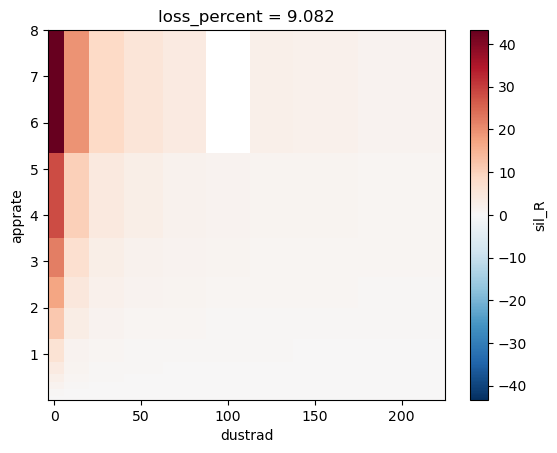

In [64]:
ds_filt['sil_R'].plot()

In [40]:
#(ds['sil_R'] - ds['cc_R'])
ds['sil_R'].

<xarray.DataArray 'sil_R' (loss_percent: 50, apprate: 13, dustrad: 9)> Size: 47kB
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00, -5.98504617e-04,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 3.78382908e-04,  2.49559572e-04,  9.83178302e-05, ...,
          9.05360016e-05, -5.98504617e-04,  1.57960138e-05],
        [ 1.46298924e-03,  6.80528827e-04,  3.19995685e-04, ...,
          9.45513513e-05,  1.89419170e-04,  1.70970397e-04],
        [ 3.61324955e-03,  1.35966152e-03,  7.34848582e-04, ...,
          1.33492915e-04,  6.78895856e-05,  2.60675394e-04],
...
        [ 2.37569084e+01,  7.48202441e+00,  3.09702098e+00, ...,
          1.02942814e+00,  9.15394444e-01,  7.65997199e-01],
        [ 3.00294059e+01,  1.11028263e+01,  4.58409970e+00, ...,
          1.41237666e+00,  1.23353172e+00,  1.01111484e+00],
        [ 4.61465463e+01,  2.07832462e+01,  9.28319723e+00, ...,
          2.64949692e+00,  2.27000051e+00,  1.79219648e+00]],

       [[ 1.85407625e-02,  1.22284190e-02,  4.81757368e-03, ...,
          4.43626408e-03, -5.98504617e-04,  7.74004674e-04],
        [ 7.16864729e-02,  3.33459125e-02,  1.56797886e-02, ...,
          4.63301622e-03,  9.28153935e-03,  8.37754945e-03],
        [ 1.77049228e-01,  6.66234145e-02,  3.60075805e-02, ...,
          6.54115283e-03,  3.32658969e-03,  1.27730943e-02],
        ...,
        [ 2.42518440e+01,  7.63789992e+00,  3.16154226e+00, ...,
          1.05087456e+00,  9.34465162e-01,  7.81955474e-01],
        [ 3.06550185e+01,  1.13341352e+01,  4.67960178e+00, ...,
          1.44180118e+00,  1.25923030e+00,  1.03217973e+00],
        [ 4.71079327e+01,  2.12162305e+01,  9.47659717e+00, ...,
          2.70469478e+00,  2.31729218e+00,  1.82953391e+00]]])
Coordinates:
  * loss_percent  (loss_percent) float64 400B 100.0 97.98 95.96 ... 3.02 1.0
  * apprate       (apprate) float64 104B 0.02 0.04 0.06667 ... 3.0 4.0 6.667
  * dustrad       (dustrad) int64 72B 1 10 30 50 75 100 125 150 200

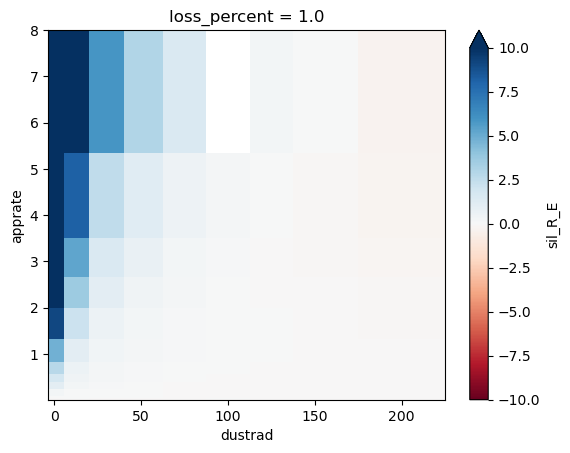

In [35]:
# ds_anom.sel(D_dustrad = 0, D_apprate = slice(-0.5, 30))['simple_subtract'].plot(vmin=-0.5, vmax=0.5, cmap='RdBu')
# ds.sel(dustrad=10)['sil_R_E'].plot()
ds.isel(loss_percent=49)['sil_R_E'].plot(vmin=-10, vmax=10, cmap='RdBu')

In [19]:
# --- get netCDR - loss rate data array
cc_app_fixed = 0.8   # [ton ha-1 yr-1] application rate used for counterfactual scenario
time_horizon = 10
# [yr] time horizon for comparing integrated CDR 
cdvar = "cdr_dif"
thissite = "site_311a"

# compute
da = cdr_compare_lossrange(df_cc, df_sil, cc_app_fixed, time_horizon, cdvar, thissite, var_fn, cdr_var)

In [27]:
# --- PLOT CC AND SIL CDR VERSUS APPLICATION RATE
plt.plot(dfcc_ar['apprate'], dfcc_ar['cdr'], c='cadetblue', linewidth=4, label='cc')
plt.plot(dfsil_ar['apprate'], dfsil_ar['cdr'], c='orange', linewidth=4, label='sil')
plt.title(str(time_horizon) + '-yr integrated CDR')
plt.xlabel('application flux (ton/ha/yr)', fontsize=14)
plt.ylabel('CDR', fontsize=14)
plt.legend()

NameError: name 'dfcc_ar' is not defined

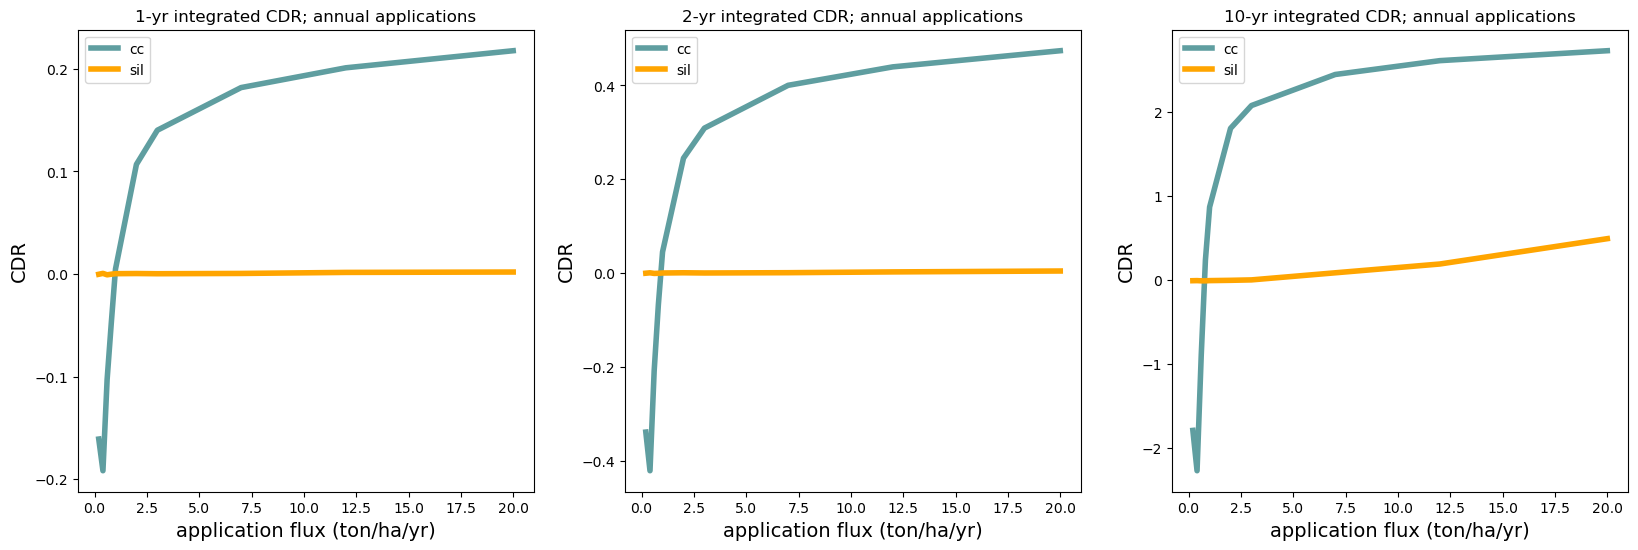

In [97]:
# --- check a couple timeslices
time_horizons = (1,2,10)     # [yr] time horizon for comparing integrated 

# set up plot grid
spec = GridSpec(ncols=3, nrows=1, hspace=0.15)
plt.figure(figsize=(20, 6))
plotdx = 0

for time_horizonx in time_horizons:
    dfcc_ar, dfsil_ar = cdr_per_apprate(df_cc, df_sil, time_horizonx, cdvar, thissite, var_fn, cdr_var)
    # make the plot
    ax = plt.subplot(spec[plotdx])
    plt.plot(dfcc_ar['apprate'], dfcc_ar['cdr'], c='cadetblue', linewidth=4, label='cc')
    plt.plot(dfsil_ar['apprate'], dfsil_ar['cdr'], c='orange', linewidth=4, label='sil')
    plt.title(str(time_horizonx) + '-yr integrated CDR; annual applications')
    plt.xlabel('application flux (ton/ha/yr)', fontsize=14)
    plt.ylabel('CDR', fontsize=14)
    plt.legend()
    
    # move to next panel
    plotdx += 1

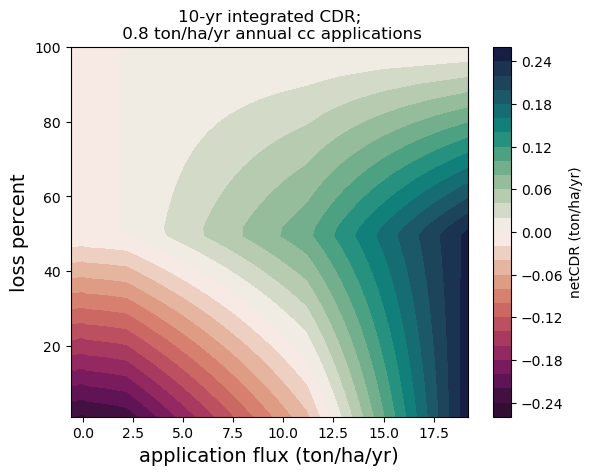

In [98]:
# --- 2d loss array
from matplotlib.colors import TwoSlopeNorm

ds = da.to_dataset(name='netcdr')
y = ds['loss_percent'].values
x = ds['D_appRate'].values

# Define the midpoint normalization
norm = TwoSlopeNorm(vmin=ds['netcdr'].min(), vmax=ds['netcdr'].max(), vcenter=0)

contour = plt.contourf(x,y,ds['netcdr'], levels=30, cmap = cmo.curl_r, norm=norm)
cbar = plt.colorbar(contour)
cbar.set_label('netCDR (ton/ha/yr)')
plt.title(str(time_horizon) + '-yr integrated CDR;\n ' + str(cc_app_fixed) + " ton/ha/yr annual cc applications")
plt.xlabel("application flux (ton/ha/yr)", fontsize=14)
plt.ylabel("loss percent", fontsize=14)
plt.show();

In [42]:
y = ds['loss_percent'].values
x = ds['D_appRate'].values

array([-0.8, -0.6, -0.4, -0.2,  0. ,  1. ,  2. ,  9. , 19. , 29. ])

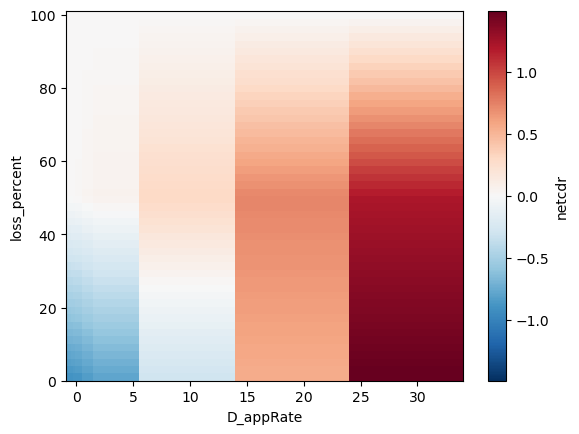

In [55]:
ds['netcdr'].plot()

In [11]:
# -----------------------

In [ ]:
# -----------------------

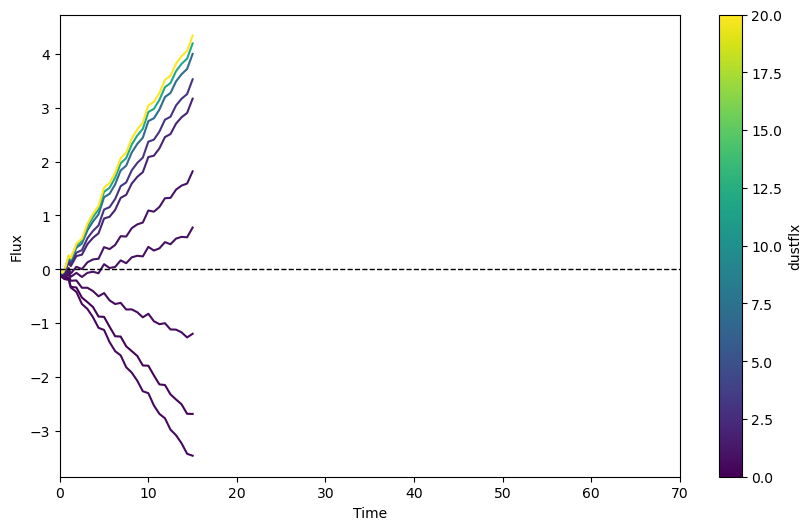

In [81]:
# --- cdr timeseries plot check
### set site
tsite = "site_311a" 
df = df_cc

dfint = df.loc[(df["ctrl"] == False) & (df["set"] == ("int_"+var_fn)) & (df["var"] == cdr_var) & (df["site"] == tsite)]
dfx = df.loc[(df["ctrl"] == False) & (df["set"] == var_fn) & (df["var"] == cdr_var) & (df["site"] == tsite)]

# which to plot
int_on = True
thisdf = dfint
cdvar = "cdr_dif"

# Group by 'iteration'
grouped = thisdf.groupby('dustrate_ton_ha_yr')

# set cmap
norm = Normalize(vmin=df['dustrate_ton_ha_yr'].min(), vmax=df['dustrate_ton_ha_yr'].max())
cmap = plt.get_cmap('viridis')

# Plotting
plt.figure(figsize=(10, 6))
for name, group in grouped:
    if int_on:
        plt.plot(group['time'], group[cdvar]*group['time'], color=cmap(norm(name)))
    else:
        plt.plot(group['time'], group[cdvar], color=cmap(norm(name)))

plt.xlim(0,70)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
# Adding labels and legend
plt.xlabel('Time')
plt.ylabel('Flux')
if cdvar in ["cdr_dif_component", "cdr_dif"]:
    if int_on:
        print("")
        #plt.ylim(-10,800)
    else:
        print("")
        # plt.ylim(-10, 30)
# plt.legend()
# Create colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('dustflx')

# Show plot
plt.show()
